# Text Classification on Consumer Complaint Dataset

This notebook demonstrates how to perform a text classification on the Consumer Complaint Dataset (available from [data.gov](https://catalog.data.gov/dataset/consumer-complaint-database)) into the following categories:

0. Credit reporting, repair, or other
1. Debt collection
2. Consumer Loan
3. Mortgage

The pipeline consists of the following steps:

1. **Explanatory Data Analysis (EDA) and Feature Engineering**
2. **Text Pre-Processing**
3. **Selection of Multi Classification Model**
4. **Comparison of Model Performance**
5. **Model Evaluation**
6. **Prediction**

## Step 1: Explanatory Data Analysis (EDA) and Feature Engineering

In this section, we load the dataset, explore its contents, and perform any necessary feature engineering. For example, we may create a new column for our target class by mapping the dataset's "Product" or related fields into one of the four defined categories.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# For text pre-processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Download nltk resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...


True

In [ ]:
# Load the consumer complaint dataset
# Note: Update the file path or URL to point to your local CSV file
data_path = 'consumer_complaints.csv'  
df = pd.read_csv(data_path, encoding='ISO-8859-1')

df_sample = df.sample(n=5000, random_state=42)
df_sample.to_csv('consumer_complaints_sample.csv', index=False)

# Display the first few rows of the dataframe
df.head()

C:\Users\jayan\AppData\Local\Temp\ipykernel_25020\1657082812.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding='ISO-8859-1')


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-01-29,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,NY,12543,NaN,NaN,Web,2025-01-29,In progress,Yes,NaN,11825440
1,2025-01-30,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,NV,89148,NaN,NaN,Web,2025-01-30,In progress,Yes,NaN,11844247
2,2025-01-29,"Payday loan, title loan, personal loan, or adv...",Installment loan,Problem when making payments,NaN,NaN,NaN,TD BANK US HOLDING COMPANY,FL,33055,NaN,NaN,Phone,2025-02-04,In progress,Yes,NaN,11824206
3,2025-01-27,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,NaN,NaN,Resurgent Capital Services L.P.,NC,27455,NaN,NaN,Postal mail,2025-01-27,In progress,Yes,NaN,11799137
4,2025-01-28,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,IL,60609,NaN,NaN,Web,2025-01-28,In progress,Yes,NaN,11810502


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7848317 entries, 0 to 7848316
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.1+

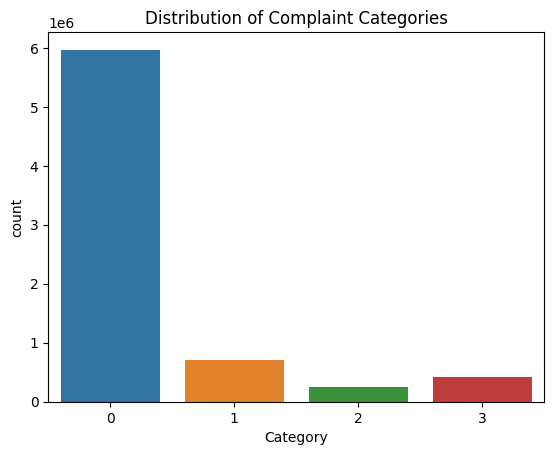

In [3]:
# Quick info and statistics
print(df.info())
print(df.describe(include='all'))

# For this example, assume the dataset has a column 'Product' and 'Consumer complaint narrative'
# We need to map the 'Product' values to our four classes. 

# Example mapping (update these mappings based on your dataset's actual content):
def map_category(product):
    if 'credit' in product.lower():
        return 0  # Credit reporting, repair, or other
    elif 'debt' in product.lower():
        return 1  # Debt collection
    elif 'loan' in product.lower():
        return 2  # Consumer Loan
    elif 'mortgage' in product.lower():
        return 3  # Mortgage
    else:
        return -1 # For products not in our defined categories

# Create a new column 'Category' by mapping the 'Product' column
df['Category'] = df['Product'].apply(map_category)

# Filter out any rows that do not match our categories
df = df[df['Category'] != -1]

# Show the distribution of categories
sns.countplot(x='Category', data=df)
plt.title('Distribution of Complaint Categories')
plt.show()

## Step 2: Text Pre-Processing

Here we clean and pre-process the text data. Typical steps include lowercasing, removing punctuation, stop words, and performing lemmatization.

In [4]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Tokenize text
    tokens = text.split()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back to string
    return ' '.join(tokens)

# Apply text cleaning on the complaint narrative column
df['Clean_Complaint'] = df['Consumer complaint narrative'].astype(str).apply(clean_text)

# Show an example of cleaned text
print(df[['Consumer complaint narrative', 'Clean_Complaint']].head())

KeyboardInterrupt: 

## Step 3: Selection of Multi Classification Model

In this section, we convert text to features using TF-IDF vectorization and then select classification models. We demonstrate using three models:

- Logistic Regression
- Random Forest Classifier
- Linear SVM

We will compare these models to select the best performing one.

In [ ]:
# Vectorize the cleaned text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['Clean_Complaint']).toarray()

# The target labels
y = df['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training data shape:', X_train.shape)
print('Test data shape:', X_test.shape)

In [ ]:
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Linear SVM': LinearSVC()
}

# Train and evaluate each model using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

# Fit the models on the training data for further evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance on Test Set")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


## Step 4: Comparison of Model Performance

After training multiple models, we compare their performance using metrics such as accuracy, precision, recall, and F1-score. The model with the best performance metrics will be selected for further evaluation.

## Step 5: Model Evaluation

Here, you can perform more detailed evaluations such as plotting the confusion matrix, ROC curves (if applicable), and analyzing misclassified examples.

In [ ]:
# Example: Plotting a confusion matrix for Logistic Regression
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get predictions from one model (e.g., Logistic Regression)
lr_model = models['Logistic Regression']
y_pred_lr = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cm, classes=["Credit Reporting", "Debt Collection", "Consumer Loan", "Mortgage"], title='Logistic Regression Confusion Matrix')
plt.show()

## Step 6: Prediction

Finally, we can use our best model to predict the category of new complaint texts. The following cell demonstrates how to preprocess new text and make a prediction.

In [ ]:
# Function to predict category for a new complaint
def predict_complaint(text, model, vectorizer):
    clean = clean_text(text)
    vect = vectorizer.transform([clean]).toarray()
    pred = model.predict(vect)[0]
    return pred

# Example usage
new_complaint = "I was charged an incorrect fee on my credit report and no one is helping me fix it."
predicted_category = predict_complaint(new_complaint, lr_model, tfidf)
print(f"Predicted Category: {predicted_category}")

# You may map the numeric prediction back to the actual category name if needed.

## Conclusion

In this notebook, we performed an end-to-end text classification task on the Consumer Complaint Dataset. We started with exploratory data analysis and feature engineering, followed by text pre-processing and converting the text data into numerical features using TF-IDF. Three classification models were trained and compared. Finally, we evaluated the models and demonstrated how to predict the category of new complaint texts.

Feel free to modify and expand this notebook based on the specifics of your dataset and further requirements.